In [1]:
import keras
from keras.callbacks import ReduceLROnPlateau
from keras.models import Sequential
from keras.layers import Dense , Conv2D , MaxPooling2D , Flatten , Dropout , BatchNormalization
from keras.applications import ResNet152V2 , MobileNetV2
from keras.preprocessing.image import ImageDataGenerator
import cv2
import os
import matplotlib.pyplot as plt
import numpy as np

In [2]:
labels = ['PNEUMONIA', 'NORMAL']
img_size = 150

def get_data(data_dir):
    data = []
    for label in labels:
        path = os.path.join(data_dir,label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                new_img = cv2.imread(os.path.join(path,img),cv2.IMREAD_GRAYSCALE)
                resized_img = cv2.resize(new_img,(img_size,img_size))
                data.append([resized_img,class_num])
            except:
                continue
    return np.array(data)      
    

In [3]:
train = get_data('E:/Chest X-Ray Images/chest_xray/chest_xray/train')
test = get_data('E:/Chest X-Ray Images/chest_xray/chest_xray/test')
val = get_data('E:/Chest X-Ray Images/chest_xray/chest_xray/val')

C:\Users\Home\anaconda3\lib\site-packages\ipykernel_launcher.py:16: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  app.launch_new_instance()


In [4]:
X_train = []
y_train = []

X_test = []
y_test = []

X_val = []
y_val = []

for img,label in train:
    X_train.append(img)
    y_train.append(label)

for img,label in test:
    X_test.append(img)
    y_test.append(label)

for img,label in val:
    X_val.append(img)
    y_val.append(label)


In [5]:
X_train = np.array(X_train)/255
X_test = np.array(X_test)/255
X_val = np.array(X_val)/255

X_train = X_train.reshape(-1,img_size,img_size,1)
X_test = X_test.reshape(-1,img_size,img_size,1)
X_val = X_val.reshape(-1,img_size,img_size,1)

y_train = np.array(y_train)
y_test = np.array(y_test)
y_val = np.array(y_val)


In [6]:
# With data augmentation to prevent overfitting and handling the imbalance in dataset

datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range = 30,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.2, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip = True,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(X_train)

In [7]:
model = Sequential()

model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu' , input_shape = (img_size,img_size,1)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2,2) , strides = 2 , padding = 'same'))

model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.1))
model.add(BatchNormalization())
model.add(MaxPooling2D((2,2) , strides = 2 , padding = 'same'))

model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2,2) , strides = 2 , padding = 'same'))

model.add(Conv2D(128 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPooling2D((2,2) , strides = 2 , padding = 'same'))

model.add(Conv2D(256 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPooling2D((2,2) , strides = 2 , padding = 'same'))

model.add(Flatten())

model.add(Dense(units = 128 , activation = 'relu'))
model.add(Dropout(0.2))

model.add(Dense(units = 1 , activation = 'sigmoid'))

model.compile(optimizer = "sgd" , loss = 'binary_crossentropy' , metrics = ['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 150, 150, 64)      640       
_________________________________________________________________
batch_normalization (BatchNo (None, 150, 150, 64)      256       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 75, 75, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 75, 75, 64)        36928     
_________________________________________________________________
dropout (Dropout)            (None, 75, 75, 64)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 75, 75, 64)        256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 38, 38, 64)        0

In [11]:
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', 
                              patience = 2, 
                              verbose=1,
                              factor=0.25, 
                              min_lr=0.000001)

In [12]:
history = model.fit(datagen.flow(X_train,y_train,batch_size=25),epochs=10,validation_data=datagen.flow(X_test,y_test),callbacks=[reduce_lr])

Epoch 1/10
209/209 [==============================] - 860s 4s/step - loss: 0.1210 - accuracy: 0.9549 - val_loss: 0.5500 - val_accuracy: 0.8125
Epoch 2/10
209/209 [==============================] - 778s 4s/step - loss: 0.1134 - accuracy: 0.9572 - val_loss: 1.2610 - val_accuracy: 0.6587
Epoch 3/10
209/209 [==============================] - 779s 4s/step - loss: 0.1164 - accuracy: 0.9572 - val_loss: 2.9044 - val_accuracy: 0.6250

Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.0006249999860301614.
Epoch 4/10
209/209 [==============================] - 778s 4s/step - loss: 0.1146 - accuracy: 0.9588 - val_loss: 0.2948 - val_accuracy: 0.8846
Epoch 5/10
209/209 [==============================] - 782s 4s/step - loss: 0.1089 - accuracy: 0.9603 - val_loss: 0.4956 - val_accuracy: 0.8125
Epoch 6/10
209/209 [==============================] - 782s 4s/step - loss: 0.1046 - accuracy: 0.9613 - val_loss: 0.3091 - val_accuracy: 0.8894
Epoch 7/10
209/209 [==============================] - 780s 4s

In [13]:
model.evaluate(X_test,y_test)

20/20 [==============================] - 14s 671ms/step - loss: 0.2710 - accuracy: 0.9151


[0.2710323929786682, 0.9150640964508057]

In [14]:
model.evaluate(X_val,y_val)

1/1 [==============================] - 0s 372ms/step - loss: 0.7348 - accuracy: 0.6250


[0.7347584366798401, 0.625]

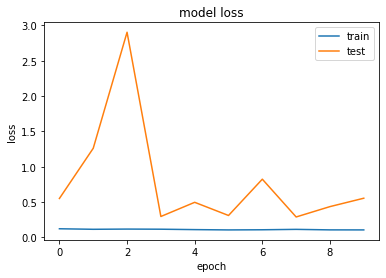

In [15]:
# plotting training set and validation test 
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

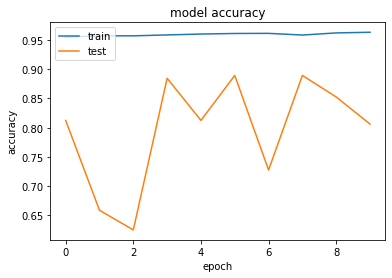

In [16]:
# plotting training set and validation test 
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [17]:
import seaborn as sns
from sklearn.metrics import classification_report,confusion_matrix

predictions = model.predict_classes(X_test)
predictions = predictions.reshape(1,-1)[0]

print(classification_report(y_test, predictions, target_names = ['Pneumonia (Class 0)','Normal (Class 1)']))

C:\Users\Home\anaconda3\lib\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


                     precision    recall  f1-score   support

Pneumonia (Class 0)       0.89      0.98      0.94       390
   Normal (Class 1)       0.96      0.81      0.88       234

           accuracy                           0.92       624
          macro avg       0.93      0.89      0.91       624
       weighted avg       0.92      0.92      0.91       624



In [18]:
cm = confusion_matrix(y_test,predictions)
cm

array([[382,   8],
       [ 45, 189]], dtype=int64)

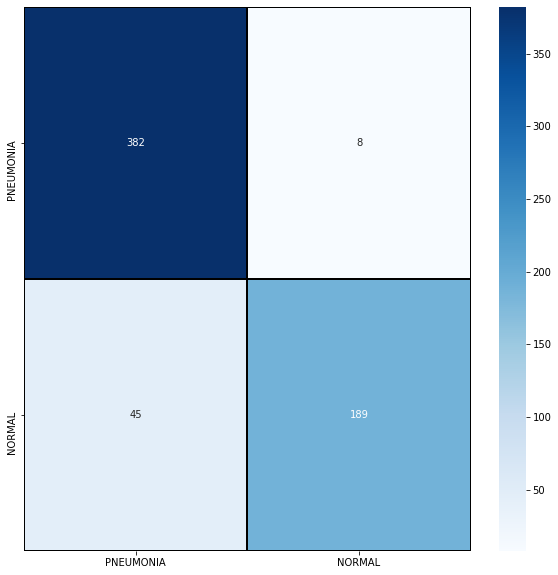

In [19]:
plt.figure(figsize = (10,10))
sns.heatmap(cm,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='',xticklabels = labels,yticklabels = labels)

In [20]:
correct = np.nonzero(predictions == y_test)[0]
incorrect = np.nonzero(predictions != y_test)[0]

In [ ]:
Some of the Correctly Predicted Classes

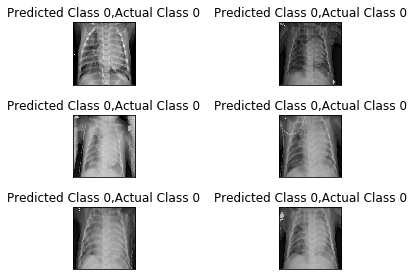

In [21]:
i = 0
for c in correct[:6]:
    plt.subplot(3,2,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(X_test[c].reshape(150,150), cmap="gray", interpolation='none')
    plt.title("Predicted Class {},Actual Class {}".format(predictions[c], y_test[c]))
    plt.tight_layout()
    i += 1

In [ ]:
Some of the Incorrectly Predicted Classes

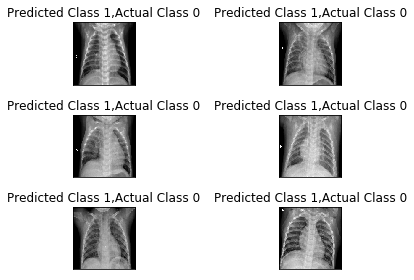

In [22]:
i = 0
for c in incorrect[:6]:
    plt.subplot(3,2,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(X_test[c].reshape(150,150), cmap="gray", interpolation='none')
    plt.title("Predicted Class {},Actual Class {}".format(predictions[c], y_test[c]))
    plt.tight_layout()
    i += 1